# ML Flow on Azure ML

The ML ops demo notebook shows running ML Flow on a local machine, and the AzureML notebook demonstrates using the Azure ML SDK for experiment tracking. This notebook combines the two, using AzureML to run, but tracking through the ML Flow API with AzureML providing the backend storage. This allows us to make use of the easily scaling  infrastructure of AzureML, while the code is still portable as other backends can easily be swapped in when required.


In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
%load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [5]:
import mlflow
mlflow.tensorflow.autolog()

In [6]:
import prd_pipeline

### Load data

In [7]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [8]:
azure_dataset_name ='sd3'
azure_experiment_name='prd_mlops_test'
azure_env_name = 'prd_ml_cluster'
cluster_name = 'mlops-test'

In [9]:
prd_model_name = 'azml_mlflow_20220504'

In [10]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [11]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

In [12]:
input_data = prd_pipeline.load_data(
    prd_ws,
    dataset_name=azure_dataset_name
)
data_splits, data_dims = prd_pipeline.preprocess_data(
    input_data,
    test_fraction=0.2,
    feature_dict={'profile': profile_features, 'single_level': single_lvl_features,'target': target_parameter,},
)

target has dims: 23
dropping zeros
getting profile columns
['air_temperature_5.0', 'air_temperature_10.0', 'air_temperature_20.0', 'air_temperature_30.0', 'air_temperature_50.0', 'air_temperature_75.0', 'air_temperature_100.0', 'air_temperature_150.0', 'air_temperature_200.0', 'air_temperature_250.0', 'air_temperature_300.0', 'air_temperature_400.0', 'air_temperature_500.0', 'air_temperature_600.0', 'air_temperature_700.0', 'air_temperature_800.0', 'air_temperature_1000.0', 'air_temperature_1250.0', 'air_temperature_1500.0', 'air_temperature_1750.0', 'air_temperature_2000.0', 'air_temperature_2250.0', 'air_temperature_2500.0', 'air_temperature_2750.0', 'air_temperature_3000.0', 'air_temperature_3250.0', 'air_temperature_3500.0', 'air_temperature_3750.0', 'air_temperature_4000.0', 'air_temperature_4500.0', 'air_temperature_5000.0', 'air_temperature_5500.0', 'air_temperature_6000.0', 'relative_humidity_5.0', 'relative_humidity_10.0', 'relative_humidity_20.0', 'relative_humidity_30.0', 'r

In [13]:
nprof_features = data_dims['nprof_features'] 
nheights = data_dims['nheights']
nsinglvl_features = data_dims['nsinglvl_features']

In [14]:
exp1 = mlflow.create_experiment('prd_exp_azml_mlflow')
exp1

'f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9'

In [15]:
exp1 = mlflow.get_experiment(exp1)

In [16]:
exp1

<Experiment: artifact_location='', experiment_id='f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9', lifecycle_stage='active', name='prd_exp_azml_mlflow', tags={}>

In [17]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [18]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# run tensorboard --logdir LOGDIRPATH from command line to launch 

In [19]:
import tempfile

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
profile_input (InputLayer)      [(None, 33, 2)]      0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 35, 2)        0           profile_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 33, 32)       192         zero_padding1d[0][0]             
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 35, 32)       0           conv1d[0][0]                     
______________________________________________________________________________________________

Using TensorFlow backend.
2022/07/05 14:02:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: module 'tensorflow.compat.v2' has no attribute '__internal__'


MAE: 10.050
R-squared score: 0.770


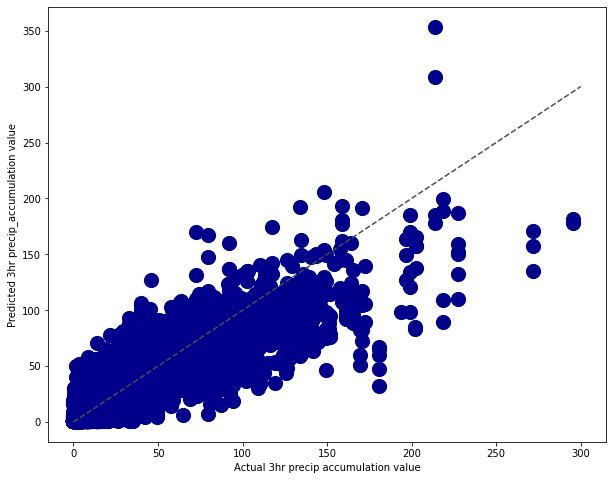

In [20]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    model = prd_pipeline.build_model(nprof_features, nheights, nsinglvl_features)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], data_splits['y_train'], epochs=50, batch_size=128, validation_data=(data_splits['X_val'], data_splits['y_val']), verbose=True, callbacks=[tensorflow_callback])

    y_pred = model.predict(data_splits['X_val'])
    error = mean_absolute_error(data_splits['y_val'], y_pred)
    print(f'MAE: {error:.3f}')
    rsqrd = r2_score(data_splits['y_val'], y_pred)
    print(f'R-squared score: {rsqrd:.3f}')
    
    mlflow.log_metric('MAE', error)
    mlflow.log_metric('R-squared', rsqrd)
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1)
    ax1.scatter(data_splits['y_val'], y_pred, s=200, c='darkblue')
    ax1.plot([0, 300], [0, 300], ls="--", c=".3")
    ax1.set_xlabel('Actual 3hr precip accumulation value')
    ax1.set_ylabel('Predicted 3hr precip_accumulation value')
#     with tempfile.TemporaryDirectory() as td1:
        
#         fig1.savefig(plot_out_path, bbox_inches='tight')
    mlflow.log_figure(fig1,  'actual_predicted_precip_3hr.png')                   
    # mlflow.log


If we look at the experiment in AzureML GUI, we see that all the model parameters have been automatically logged, and the model has been saved by ML Flow ready for use in inference.

## Evaluation

In [ ]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(data_splits['y_val'], alpha=0.5, bins=40, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
plt.legend()
plt.show()